# Dog Breed Classifier

###  Let's build a Dog Breed Identification App!

Have you ever walked past a dog and wondered what breed it is?

The task of assigning breed to dogs from images is actually pretty challenging, look at the contrasting breeds below! Even I (human) had a tough time with it..

<table>
    <tr>
        <th> Breed: Brittany </th><th> Breed: Welsh Springer Spaniel </th> <th></th> <th> Breed: Curly-Coated Retriever </th><th> Breed: American Water Spaniel </th>
    </tr>
    <tr><td> 
        <img src="examples/Brittany_02625.jpg" style="height:150px"></img>
    </td><td> 
        <img src="examples/Welsh_springer_spaniel_08203.jpg" style="height:150px"></img>
    </td><td>
    </td><td>
        <img src="examples/Curly-coated_retriever_03896.jpg" style="height:150px"></img>
    </td><td>
        <img src="examples/American_water_spaniel_00648.jpg" style="height:150px"></img>
    </td></tr>
</table>

This notebook assumes that you have prior knowledge on [convolutional neural networks](https://en.wikipedia.org/wiki/Convolutional_neural_network) and [transfer learning](https://en.wikipedia.org/wiki/Transfer_learning). Very briefly, transfer learning attempts to transfer the knowledge in a trained model (usually from a related domain) to help learning in a new target domain. In practice, this is often effected through partial to full training of a pre-trained model. For image recognition exercises (such as our dog breed predictor) we can use high-performance pre-trained models such deep convolutional model such as AlexNet, VGG or ResNet as a starting point.

### Contents

1. Import Datasets
1. Build A Dog Breed Classifier
1. Deploy the Model

### [1] Import Datasets

We'll be using the [Stanford dog dataset](http://vision.stanford.edu/aditya86/ImageNetDogs/) that [Udacity](https://www.udacity.com/), a popular Massive Open Online Course provider, has prepared into - train, test and validation folders. The download and extraction of data will take quite a bit of time, around 30 mins. Please go for a run or have a meal while it loads..

In [ ]:
!mkdir data

In [ ]:
import requests

r = requests.get('https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip')
if r.status_code == 200:
    with open('data/dogImages.zip', 'wb') as f:
        f.write(r.content)

In [ ]:
# this will take roughly 20-30mins
from zipfile import ZipFile

with ZipFile('data/dogImages.zip', 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall('data/')

#### [1.1] Exploratory Visualizations

Let's explore the dimensions of the images as well as the class balance amongs the different breeds.

In [2]:
import requests
import numpy as np
from glob import glob

# load filenames for dog images
dog_files = np.array(glob("data/dogImages/*/*/*"))

# print number of images in each dataset
print('There are %d total dog images.' % len(dog_files))

There are 8351 total dog images.


In [3]:
# this may take a couple of minutes
from PIL import Image
import matplotlib.pyplot as plt                        
%matplotlib inline

x_dim = []
y_dim = []

# check the image dimensions
for pic_dir in dog_files:
    img = Image.open(pic_dir)
    width, height = img.size
    x_dim.append(width)
    y_dim.append(height)

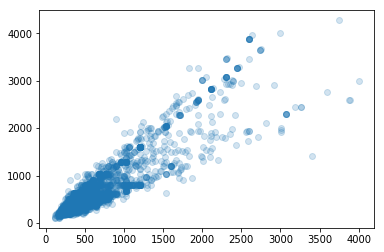

In [4]:
plt.scatter(y_dim, x_dim, alpha = 0.2)
plt.show()

Looks like we have images of different dimensions.. Let's keep this in mind to resize them later.

Check the number of classes (dog breeds in the dataset)

In [5]:
classes = glob('data/dogImages/train/*')
class_count = []

for folder_dir in classes:
    directory = folder_dir + '/*'
    img_list = glob(directory)
    class_count.append(len(img_list))

In [6]:
print('There are {} different breeds in our dataset'.format(len(classes)))

There are 133 different breeds in our dataset


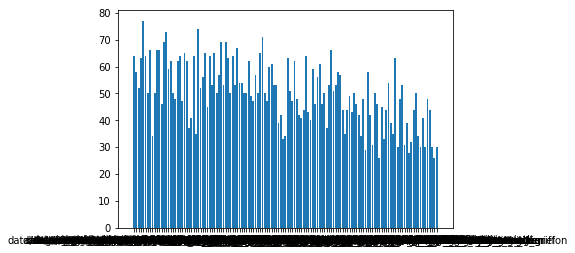

In [7]:
plt.bar(classes, class_count)
plt.show()

It seems like the classes are pretty balanced!

---
### [2] Building A Dog Breed Classifier

Remember that the dimensions of the images vary so we need to add some resizing and crop into a transformation step that occurs before loading. Let's prepare the data by building some transformation steps as then go ahead to define the data loaders.

For this notebook, we'll be using [pytorch](https://pytorch.org/), a very popular open source machine learning framework to implement our classifier. Pytorch allows numerical calculations with GPU and provides a flexible and fast deep learning platform with clear and simple syntax. To learn more about pytorch, do check out their [introduction here](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html).

A quick introduction of the transformation functions used:
* Resize - Resizes a given image to the specified dimensions
* CenterCrop - Crops a given image at its center by the given size
* RandomHorizontalFlip - Horizontally flip the given image randomly with a specified probability.
* RandomResizedCrop - A crop of random size of the original size and a random aspect ratio (default: of 3/4 to 4/3) of the original aspect ratio is made followed by a resize
* Compose - A pipeline to combine several transformation steps

Also, we are normalizing the image intensity values to a known mean and standard deviation calculated from the [ImageNet dataset](http://www.image-net.org/).

In [8]:
!pip install torch torchvision

In [16]:
from torchvision import datasets
import torch
import torchvision.transforms as transforms
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Specify appropriate transforms, and batch_sizes
data_dir = 'data/dogImages'

# define data transformation
normalization = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])

# employ a random resized crop and random horizontal flip in train
# to closely simulate real scenarios of users uploading images where
# the dog might be in a small corner of the image or in a different orientation
data_transforms = {'train': transforms.Compose([transforms.RandomResizedCrop(224),
                                                transforms.RandomHorizontalFlip(),
                                                transforms.ToTensor(),
                                                normalization]),
                   'validation': transforms.Compose([transforms.Resize(256),
                                                     transforms.CenterCrop(224),
                                                     transforms.ToTensor(),
                                                     normalization]),
                   'test': transforms.Compose([transforms.Resize(256),
                                               transforms.CenterCrop(224),
                                               transforms.ToTensor(),
                                               normalization])
                  }

train_data = datasets.ImageFolder(data_dir + '/train', transform=data_transforms['train'])
valid_data = datasets.ImageFolder(data_dir + '/valid',   transform=data_transforms['validation'])
test_data  = datasets.ImageFolder(data_dir + '/test',  transform=data_transforms['test'])

In [17]:
# Define data loaders
num_workers = 0
batch_size = 20

train_loader = torch.utils.data.DataLoader(train_data,
                                           batch_size=batch_size, 
                                           num_workers=num_workers,
                                           shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data,
                                           batch_size=batch_size, 
                                           num_workers=num_workers,
                                           shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data,
                                           batch_size=batch_size, 
                                           num_workers=num_workers,
                                           shuffle=False)

loaders_transfer = {
    'train': train_loader,
    'valid': valid_loader,
    'test' : test_loader
}

#### Now, let's create our transfer learning model with a modified prediction layer. 

Pytorch provides pre-trained models that have been trained on the [ImageNet database](http://www.image-net.org/) of over 14M images. These models are already able to identify many different objects in an image. There are [different strategies for transfer learning](https://towardsdatascience.com/transfer-learning-from-pre-trained-models-f2393f124751), each with different considerations, as shown in the image below. What we'll be focusing on is the 3rd strategy - to freeze the convolutional layers and train the final prediction layer to predict the different dog breeds - as our data set size is relatively small and rather similar to the ImageNet databse.

<img src="examples/transfer_strategies.png" width="600">

We've opted to use a pre-trained [MobileNetV2 model](https://arxiv.org/pdf/1801.04381.pdf) as it's fast to train and small enough to be deployable on even mobile phones. Please feel free to explore [other pre-trained models](https://pytorch.org/docs/stable/torchvision/models.html) and modify the network to improve the accuracy.

In [11]:
import torch
import torch.nn as nn
import torchvision.models as models

model_transfer = models.mobilenet_v2(pretrained=True)

# freeze the mobile net weights
for param in model_transfer.parameters():
    param.requires_grad = False
    
model_transfer.classifier[1] = nn.Linear(1280, len(classes), bias=True)
classifier_parameters = model_transfer.classifier.parameters()

# back prop on the fc weights
for param in classifier_parameters:
    param.requires_grad = True

# shift to GPU if available
use_cuda = torch.cuda.is_available()

if use_cuda:
    model_transfer = model_transfer.cuda()

### Specify Loss Function and Optimizer

We'll use [Cross Entropy Loss](https://en.wikipedia.org/wiki/Cross_entropy) as our loss function since this is a classification problem as well as an [Adam optimizer](https://arxiv.org/pdf/1412.6980.pdf) as it is computationally efficient and straightforward to implement. Do feel free to use other [loss functions](https://ml-cheatsheet.readthedocs.io/en/latest/loss_functions.html) and [optimizers](https://ruder.io/optimizing-gradient-descent/).

In [13]:
import torch.optim as optim

criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = optim.Adam(model_transfer.classifier.parameters(), lr=0.002)

### Train and Validate the Model

Let's train our transfer learning model to assign breeds to dogs!

Please note that this step may take quite a while, about 2-3 hours on a CPU or a few minutes on a GPU.

In [22]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            # initialize weights to zero
            optimizer.zero_grad()
            output = model(data)
            
            # calculate loss
            loss = criterion(output, target)
            
            # back prop
            loss.backward()
            
            # grad
            optimizer.step()
            
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
            if batch_idx % 100 == 0:
                print('Epoch %d, Batch %d loss: %.6f' %
                  (epoch, batch_idx + 1, train_loss))
        
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            output = model(data)
            loss = criterion(output, target)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))

            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## save the model if validation loss has decreased
        if valid_loss < valid_loss_min:
            torch.save(model.state_dict(), save_path)
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            valid_loss_min = valid_loss
            
    # return trained model
    return model

In [23]:
# train the model
# 2-3 hours on CPU, a few minutes on GPU
model_transfer = train(5, loaders_transfer, model_transfer, optimizer_transfer,
                       criterion_transfer, use_cuda, 'model_transfer.pt')

Epoch 1, Batch 1 loss: 1.316708
Epoch 1, Batch 101 loss: 1.285141
Epoch 1, Batch 201 loss: 1.216960
Epoch 1, Batch 301 loss: 1.213792
Epoch: 1 	Training Loss: 1.225483 	Validation Loss: 0.747065
Validation loss decreased (inf --> 0.747065).  Saving model ...
Epoch 2, Batch 1 loss: 1.779122
Epoch 2, Batch 101 loss: 1.121530
Epoch 2, Batch 201 loss: 1.133293
Epoch 2, Batch 301 loss: 1.160305
Epoch: 2 	Training Loss: 1.165946 	Validation Loss: 0.811088
Epoch 3, Batch 1 loss: 1.196164
Epoch 3, Batch 101 loss: 1.136027
Epoch 3, Batch 201 loss: 1.152362
Epoch 3, Batch 301 loss: 1.164261
Epoch: 3 	Training Loss: 1.171939 	Validation Loss: 0.761670
Epoch 4, Batch 1 loss: 0.900636
Epoch 4, Batch 101 loss: 1.052627
Epoch 4, Batch 201 loss: 1.142140
Epoch 4, Batch 301 loss: 1.182858
Epoch: 4 	Training Loss: 1.191318 	Validation Loss: 0.783834
Epoch 5, Batch 1 loss: 1.012414
Epoch 5, Batch 101 loss: 1.049022
Epoch 5, Batch 201 loss: 1.019521
Epoch 5, Batch 301 loss: 1.062644
Epoch: 5 	Training Los

In [24]:
# load the model that got the best validation accuracy
model_transfer.load_state_dict(torch.load('model_transfer.pt', map_location=torch.device('cpu')))

<All keys matched successfully>

In [25]:
# you may alternatively also choose to save it as a pickle file for any other purposes
torch.save(model_transfer, 'model_transfer.pth')

In [26]:
# create a list of class names corresponding to the output from the predictor
import json
import re

classes = loaders_transfer['train'].dataset.classes

# clean up the class names
class_res = []
for class_ in classes:
    out = re.sub('^[a-zA-Z0-9]*\.', '', class_)
    out = re.sub('-|_', ' ', out)
    out = ' '.join(w.capitalize() for w in out.split())
    class_res.append(out)
    
# save a list of classes for use in inference
with open("classes.json", 'w') as f:
    json.dump(class_res, f) 

### Test the Model

After all the hardwork, it's time to test our model!

In [38]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(torch.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))


In [39]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.777790


Test Accuracy: 79% (664/836)


#### 79% Accuracy is way better than what I can do!